In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeCV

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support

from imblearn.over_sampling import SMOTE

import os
from sklearn.model_selection import GridSearchCV
# os.environ['CUDA_VISIBLE_DEVICES']='7'

### Step 1: Read data

In [3]:
#read data
df_t1 = pd.read_csv('radiomics_t1_dilated.csv')
df_t2 = pd.read_csv('radiomics_t2_dilated.csv')
df_label = pd.read_csv('label.csv')
df_volume = pd.read_csv('volume.csv')

#merge label, volume and t2
df_t2.columns = ['t2_'+str(col) for col in df_t2.columns]  # add_prefix
df_t2 = df_t2.rename(columns={'t2_patient': 'patient'})

df_labeled = df_t1.merge(df_t2, on='patient')   #merge t2
df_labeled = df_labeled.merge(df_volume, on ='patient')   #merge volume
df_labeled = df_labeled.merge(df_label,on = 'patient')   

# df_labeled = df_labeled[df_labeled.label<3]
df_labeled.drop_duplicates(subset=['patient'],inplace=True)
print(df_labeled)
print(df_labeled['label'].value_counts())

# df_labeled.to_csv('radiomics_labeled.csv',index=False)


     patient  original_shape_Elongation  original_shape_Flatness  \
0    CAD-196                   0.189256                 0.162140   
1     CAD-73                   0.351586                 0.198430   
2    CAD-293                   0.334404                 0.150629   
3     CAD-34                   0.297753                 0.165886   
4    CAD-289                   0.369507                 0.191274   
..       ...                        ...                      ...   
241   MCF-18                   0.384588                 0.260835   
242   MCF-04                   0.422619                 0.306136   
243   MCF-20                   0.607026                 0.451363   
244   MCF-26                   0.528133                 0.279510   
245   MCF-16                   0.496012                 0.343139   

     original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
0                         27.055452                      166.864661   
1                         28.300023      

In [3]:
###Alternative: load labeled df directly
df_labeled = pd.read_csv('uvscaling_t.csv')
df_labeled = df_labeled.drop('Unnamed: 0', axis=1)
print(df_labeled)
print(df_labeled['label'].value_counts())

              patient  label  t2_original_shape_Elongation  \
0             CAD-226      2                     -1.438885   
1     NU_Patient_0008      0                     -0.509125   
2               AHN21      2                     -0.390296   
3             CAD-205      2                      0.168286   
4             CAD-181      1                      1.280118   
..                ...    ...                           ...   
226  nyu_Patient_0083      0                      0.009747   
227  nyu_Patient_0150      1                      0.256494   
228             MCA02      1                      0.061023   
229           CAD-252      2                     -0.379709   
230           CAD-262      2                     -1.282669   

     t2_original_shape_Flatness  t2_original_shape_LeastAxisLength  \
0                     -0.801203                          -0.607752   
1                      0.857875                           0.772158   
2                      0.814546              

### Step 2: Feature selection

In [4]:
import statsmodels.formula.api as sm
from statsmodels.formula.api import ols 

from sklearn.feature_selection import SelectKBest, chi2,f_classif

X = df_labeled.iloc[:,2:]
Y = df_labeled.label

X_selected = SelectKBest(f_classif, k=108).fit_transform(X, Y)
# print(X_selected)
X_selected.shape
# print(X_selected)

(231, 108)

### Step 3: Grid Search

In [35]:
# from sklearn.model_selection import GridSearchCV

In [5]:
estimator = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    seed=42
)
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(20, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 10,
    cv = 5,
    verbose=True
)
grid_search.fit(X_selected, Y)

print(grid_search.best_estimator_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=140, n_jobs=0,
              num_class=3, num_parallel_tree=1, objective='multi:softmax', ...)


### Step 4: Training, testing and evaluation

pred: [0 1 1 1 2 1 0 2 2 1 1 0 2 1 0 2 0 0 1 2 2 1 0 1 0 1 0 1 1 2 2 2 1 1 0 1 2
 2 2 0 2 1 2 2 1 2 1]
true: [0 1 2 1 0 1 1 2 2 1 1 0 1 2 0 2 0 0 1 2 2 1 1 1 0 1 0 1 1 2 2 2 2 1 0 0 2
 2 1 0 1 1 2 1 1 2 1]
accuracy = 76.595745%
confusion matrix =
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.79      0.71      0.75        21
           2       0.71      0.80      0.75        15

    accuracy                           0.77        47
   macro avg       0.77      0.78      0.77        47
weighted avg       0.77      0.77      0.77        47

[0.81818182 0.78947368 0.70588235] [0.81818182 0.71428571 0.8       ] [0.81818182 0.75       0.75      ] [11 21 15]


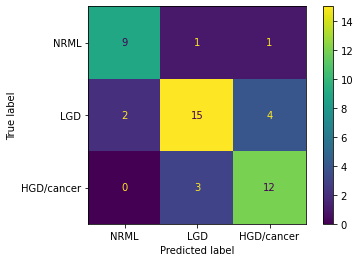

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, Y, test_size=.2)
# bst = XGBClassifier(n_estimators=180, max_depth=4,objective='multi:softmax',num_class=3)
# bst = XGBClassifier(n_estimators=20, max_depth=4,objective='multi:softmax',num_class=4)
bst = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, 
              monotone_constraints='()', n_estimators=140, n_jobs=0,
              num_class=3, num_parallel_tree=1, objective='multi:softmax')
# create model instance
# sm = SMOTE(random_state=42)
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

bst.fit(X_train, y_train) # fit model
y_pred = bst.predict(X_test) # make predictions
y_true = y_test.to_numpy()
print('pred:',y_pred)
print('true:',y_true)

#evaluation
# accuracy = np.count_nonzero(y_true-y_pred)/len(y_pred)
accuracy = np.mean(y_true == y_pred)
print('accuracy = {:%}'.format(accuracy))
print('confusion matrix =')
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels= ['NRML','LGD','HGD/cancer']).plot()

report = classification_report(y_true, y_pred)
print(report)

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
print(precision, recall, f1, support)
# Calculate ROC AUC score for each class
# auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
# print("ROC AUC score: ", auc)
# cm_display = ConfusionMatrixDisplay(cm, display_labels= ['NRML','LGD','HGD']).plot()

### Step 5: Validation_Repeated Trials

In [9]:
s = 0
a = 0
n = 10

precision_list = []
recall_list = []
f1_list=[]
support_list=[]
for i in range(1,n+1):
    print(i,'th trial:')
    X_train, X_test, y_train, y_test = train_test_split(X_selected, Y, test_size=.2)

    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    bst = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, 
              monotone_constraints='()', n_estimators=140, n_jobs=0,
              num_class=3, num_parallel_tree=1, objective='multi:softmax')

    # bst = XGBClassifier(n_estimators=180, max_depth=4,objective='multi:softmax',num_class=4)
    # bst = XGBClassifier(n_estimators=20, max_depth=4,objective='multi:softmax',num_class=4)

    bst.fit(X_train_res, y_train_res)
    y_pred = bst.predict(X_test)
    y_true = y_test.to_numpy()
    # accuracy = np.count_nonzero(y_true-y_pred)/len(y_pred)
    accuracy = np.mean(y_true == y_pred)

    # Calculate classification report containing precision, recall, and F1 score for each class
    report = classification_report(y_true, y_pred)
    print(report)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    support_list.append(support)

    s+=accuracy
    print('data size: X train resampling + Xtest = ',len(y_train_res)+len(y_test))
    print('current accuracy:',accuracy)
    print('mean accuracy till now:',s/i)
    # print('mean auc:', a/i)


1 th trial:
              precision    recall  f1-score   support

           0       0.71      0.86      0.77        14
           1       0.56      0.53      0.55        17
           2       0.71      0.62      0.67        16

    accuracy                           0.66        47
   macro avg       0.66      0.67      0.66        47
weighted avg       0.66      0.66      0.65        47

data size: X train resampling + Xtest =  239
current accuracy: 0.6595744680851063
mean accuracy till now: 0.6595744680851063
2 th trial:
              precision    recall  f1-score   support

           0       0.64      0.41      0.50        17
           1       0.43      0.67      0.53        15
           2       0.69      0.60      0.64        15

    accuracy                           0.55        47
   macro avg       0.59      0.56      0.56        47
weighted avg       0.59      0.55      0.55        47

data size: X train resampling + Xtest =  245
current accuracy: 0.5531914893617021
mean ac

In [12]:
print('Mean accuracy:',s/n)
print('labels: 0 1 2')
print('Mean precision:',np.mean(np.array(precision_list),axis=0))
print('Mean recall:',np.mean(np.array(recall_list),axis=0))
print('Mean f1:',np.mean(np.array(f1_list),axis=0))


Mean accuracy: 0.6531914893617021
labels: 0 1 2
Mean precision: [0.68330373 0.5921861  0.6800147 ]
Mean recall: [0.62001459 0.56553659 0.73937393]
Mean f1: [0.63827363 0.57275247 0.70580053]
